# **Natalia's and Karina's workshop on timeseries and models**

We will explore dataset of daily female birth from Kaggle 🌸🤱🏽👧🏼

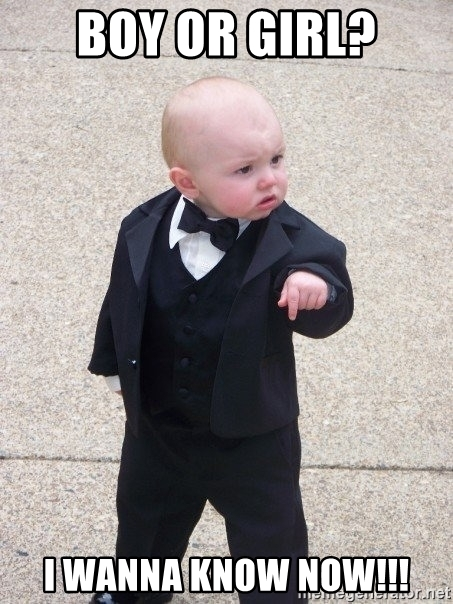

In [ ]:
from IPython.display import display, Image
display(Image(filename='/work/boy-or-girl-i-wanna-know-now.jpg'))

<hr color=grey>

1) **Firtsly, we need to install all necessary libraries for working with timeseries**

In [ ]:
import pandas as pd #work with datasets
import statsmodels # for test in statistics
import matplotlib.pyplot as plt # for plotting
import statsmodels.api as sm
import numpy as np

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv', sep=',', encoding='utf-8-sig') #read our ABT

Let us look at it:

In [ ]:
df.head()

,Date,Births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


Here we see 2 columns: first one is day and the second on is units of girls.

In [ ]:
type(df)

pandas.core.frame.DataFrame

See that we have type of the dataset is DATAFRAME - it is not ok to work with it -> we will rewrite it as Series:

In [ ]:
df["Date"] = pd.to_datetime(df["Date"])
series_birth = pd.Series(df['Births'].values , index=df['Date']).fillna(0) 
series_birth = series_birth.asfreq('d')

In [ ]:
series_birth

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
              ..
1959-12-27    37
1959-12-28    52
1959-12-29    48
1959-12-30    55
1959-12-31    50
Freq: D, Length: 365, dtype: int64

In [ ]:
type(series_birth)

pandas.core.series.Series

<hr color=grey>

2) **Add special libraries for work with time-series data:**

In [ ]:
!pip install sktime # unification with the convenience of different models for rows

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


SKTIME - a unified framework for machine learning with time series

read more here https://www.sktime.org/en/latest/ 🌚

<hr color=grey>

3) **Visualization of our time-series of daily female birth**

In [ ]:
from sktime.utils.plotting import plot_series

In [ ]:
series_birth

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
              ..
1959-12-27    37
1959-12-28    52
1959-12-29    48
1959-12-30    55
1959-12-31    50
Freq: D, Length: 365, dtype: int64

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

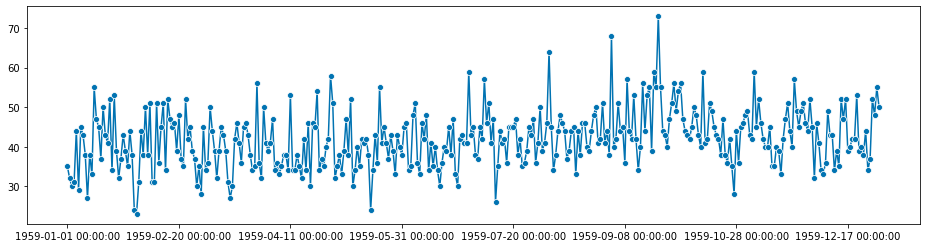

In [ ]:
plot_series(series_birth)

Here you can see the beautiful plot with very unclear trend.

<hr color=grey>

4) **Dividing into test and train part for further training on forecasting models**

Use library to divide on test and train part:

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split

In mostly cases of machine learning it is ok to use 30% of given data as test size, we will do it:

In [ ]:
y_train, y_test = temporal_train_test_split(series_birth, test_size=30)

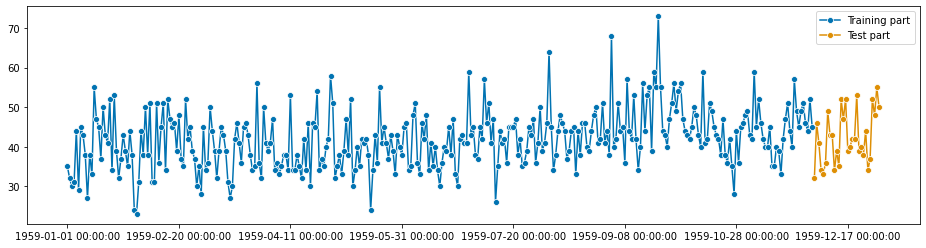

In [ ]:
plot_series(y_train, y_test, labels=['Training part', 'Test part']);

<hr color=grey>

4) **Checking for stationarity**

Identifying whether a time series is stationary or non-stationary is very important. If it is stationary you can use ARIMA models to predict the next values of the time series. If it is non-stationary then you cannot use ARIMA models :(

The augmented Dicky-Fuller test is the most common test to identify whether a time series is non-stationary. This is a statistical test, where the null hypothesis is that your time series is non-stationary due to trend. 

Let us do ot with Dicky-Fuller test on the births time series to test for stationarity: 

In [ ]:
# Import augmented dicky-fuller test function
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Run dicky-fuller test 
result = adfuller(df['Births'])

!!! So let us see that if data is not stationary this would mean that the number of births of girls per day has a trend (changing)  

We can check stationarity by looking twice at a plot and also considering Dicky-Fuller test

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

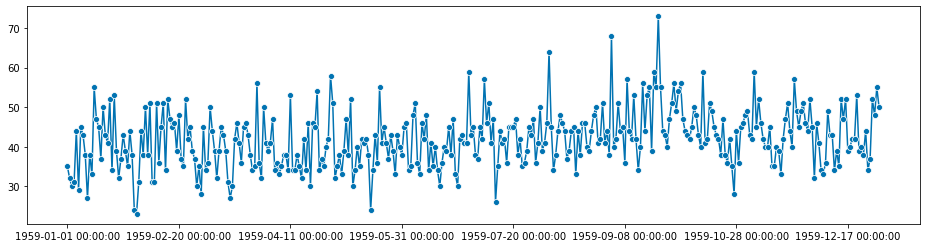

In [ ]:
plot_series(series_birth)

In [ ]:
# Print test statistic
print('ADF Statistic:', result[0])

# Print p-value
print('p-value:', result[1])

ADF Statistic: -4.808291253559764
p-value: 5.2434129901498554e-05


Interpreting the test result: 

- The zeroth element is the test statistic, in this case it is -4.808. The more negative this number is, the more likely that the data is stationary. 

Therefore, the data is likely to be stationary. 

- The first item in the results tuple, is the test p-value, in this case it is 5.243e-05. If the p-value is smaller than 0.05, we reject the null hypothesis that time series is non-stationary. 

Therefore, we assume that the time series must be stationary. 

Is it stationary? 
**Yes**, the plot appears to be stationary: 
- because the plot does not have a trend 
- because in the plot, the variance does not change with time 

<hr color=grey>

5) **Seasonal decompose**

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


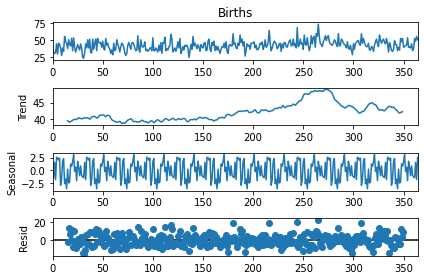

In [ ]:
# Perform additive decomposition
decomp = seasonal_decompose(df['Births'], freq=30)

# Plot decomposition
decomp.plot();
plt.tight_layout();
plt.show()

You may think of a time series as composed of components of pattern, periodic and residual. When you go about modeling it, this can be a nice way to think about the data. You will break it down into these elements if you know the length of the time sequence.

<hr color=grey>

6) **Test this data for seasonality**


This is how we choose which ARIMA model to fit. 

One of the main ways to identify the correct model order is by using 
- the autocorrelation function, the ACF (the set of correlation values for different lags) 
- the partial autocorrelation function the PACF (the correlation between a time series and the lagged version of itself after we subtract the effect of correlation at smaller lags) 

To make a model (ARIMA, ARMA, AR, MA) we firstly have to decide which one we want to fit. 

By comparing the ACF and PACF for the time series, we can determine the order of the model. 

Here, how we can determine different types of models: 

- If the amplitude of the ACF tails off with increasing lag and the PACF cuts off after some lag p, then we have a AR(p) model. 

- If the amplitude of the ACF cuts off after some lag q and the amplitude of the PACF tails off then we have a MA(q) model. 

- If both the ACF and PACF tail off then we have an ARMA model. 


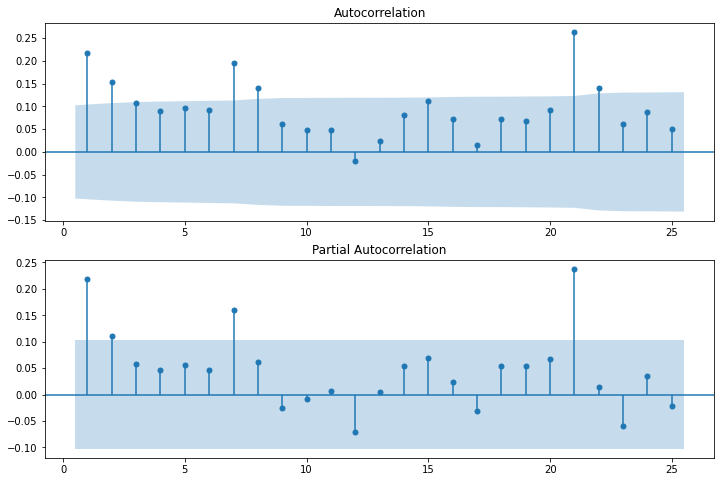

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8)) 
 
# Plot the ACF 
plot_acf(df['Births'], lags=25, zero=False, ax=ax1)

# Plot the PACF 
plot_pacf(df['Births'], lags=25, zero=False, ax=ax2)

plt.show()

According to the graphs, we can conclude that both the ACF and PACF tail off, theferore we have an ARMA model. 

* It is also important to remember that the time series must be stationary before making these plots. 

You can notice that if the ACF values are high and tail off very very slowly, this might mean that the data is non-stationarity. In such case, it needs to be differenced. 
Also, if the autocorrelation at lag-1 is very negative, this might mean that you have taken the difference too many times. 

So, now we have to apply the ARMA(p,q). 

<hr color=grey>

7) **Searching over model order (p and q)** 

Since both of the orders p and q are non-zero, we can't use the ACF and PACF to choose the order of a model. 
In this case, we will use the AIC and the BIC. 

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(3):
  # Loop over q values from 0-2
    for q in range(3):
      	# create and fit ARMA(p,q) model
        model = SARIMAX(df['Births'], order=(p, 0, q)) 
        results = model.fit()
        
        # Append order and results tuple
        order_aic_bic.append((p, q, results.aic, results.bic)) 

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [ ]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'q', 'AIC', 'BIC']) 

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC')) 

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC')) 

   p  q          AIC          BIC
7  2  1  2471.357849  2486.957438
5  1  2  2471.852868  2487.452458
8  2  2  2473.205920  2492.705406
4  1  1  2474.495617  2486.195309
6  2  0  2574.084165  2585.783857
3  1  0  2656.890623  2664.690417
2  0  2  3188.684083  3200.383775
1  0  1  3407.163868  3414.963663
0  0  0  3776.975953  3780.875850
   p  q          AIC          BIC
4  1  1  2474.495617  2486.195309
7  2  1  2471.357849  2486.957438
5  1  2  2471.852868  2487.452458
8  2  2  2473.205920  2492.705406
6  2  0  2574.084165  2585.783857
3  1  0  2656.890623  2664.690417
2  0  2  3188.684083  3200.383775
1  0  1  3407.163868  3414.963663
0  0  0  3776.975953  3780.875850


We are sorting by the AIC score and also by the BIC score. 
We will choose the model with the lowest AIC score - (p, q) = (2, 1) (it is also in the second place (by minimum values), according to the BIC score). 

Now we know the order, p = 2 and q = 1. 
We can create a model, fit it and print the summary. 

<hr color=grey>

8) **ARIMA models** 

ARIMA - autoregressive integrated moving average model. 

We cannot apply an ARMA model to non-stationary time series. 

In case of non-stationary time series, we need to take the difference of the time series to make it stationary. Only then can we model it. 

We have shown above that our time series are stationary, therefore, we do not have to need to take the difference of the time series to make it stationary. 

We can implement an ARIMA model using the SARIMAX model class from statsmodels. 

The ARIMA model has three model orders: 
- p the autoregressive order 
- d the order of differencing 
- q the moving average order 

ARMA model - setting the middle order parameter d to zero. 

ARIMA(p, 0, q) = ARMA(p, q) 

As we already have a stationary data, we do not have to difference the time series data. 

This means that the middle order parameter d == 0, therefore, we will use the ARMA model. 

We have to apply an ARMA(2,1) model. We fit the model as before and make forecasts. 

However, if your time series data is non-stationary, you have to select the right amount of differencing carefully. 
It is important to understand that you have to difference the data only until it is stationary and no more. 

After differencing, you have to check if the time series is stationary. 

In [ ]:
# Import the ARMA model
from statsmodels.tsa.arima_model import ARMA 

# Instantiate the model
model = ARMA(y_train, order=(2, 1)) 

# Fit the model
results = model.fit() 

# Print model fit summary
print(results.summary()) 

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  335
Model:  

<hr color=grey>

9) **One-step-ahead prediction** 

We can make lots of these predictions in-sample in the time frame for which we have data; to approximate the next ones, use the previous series value. A one-step-ahead forecast is called this.

In [ ]:
one_step_forecast = results.forecast(steps=30) #for future 30 days

# Extract prediction mean 
mean_forecast = np.array(one_step_forecast[0]) 

# Get confidence intervals of  predictions 
confidence_intervals = np.array(one_step_forecast[2])

# Select lower and upper confidence limits 
lower_limits = confidence_intervals[:,0]
upper_limits = confidence_intervals[:,1]

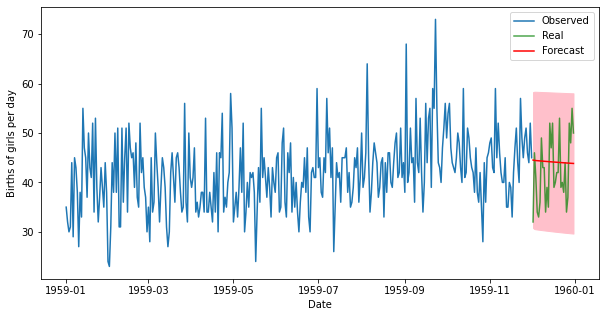

In [ ]:
plt.figure(figsize = (10, 5))

plt.plot(y_train.index, y_train, label='Observed');
plt.plot(y_test.index, y_test, label='Real', color='g', alpha=0.7);

plt.plot(y_test.index, mean_forecast, color='r', label='Forecast');
plt.fill_between(y_test.index, lower_limits, upper_limits, color='pink');

# Set labels, legends
plt.xlabel('Date');
plt.ylabel('Births of girls per day');
plt.legend();

For the last 30 days with data available, we made forecasts, still predicting only one day forward. You will determine how the model performs in making predictions for the next day, where you do not know the result, by testing these predictions.


<hr color=grey>

10) **Better prediction - SARIMAX** 

Add library and start work with SARIMAX - this model class can do everything that can be achieved by the ARMA model class and can be generalized even further. 
What's important now is that a SARIMAX model with order (p, 0, q) is exactly the same as an ARMA (p, q) model. 

So, as the data is already stationary, we do not have to difference the time series data. 

This means that the model will be SARIMAX(2, 0, 1), which is the same as an ARMA(2,1) model. 

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
model = SARIMAX(y_train, order=(2, 0, 1),      #####
                enforce_invertibility=False,
                enforce_stationarity=False,
                simple_differencing=False, 
                measurement_error=False,
                k_trend=0)
results = model.fit()

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  335
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -1122.602
Date:                Mon, 01 Feb 2021   AIC                           2253.203
Time:                        19:08:23   BIC                           2268.436
Sample:                    01-01-1959   HQIC                          2259.277
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1237      0.058     19.310      0.000       1.010       1.238
ar.L2         -0.1232      0.058     -2.117      0.034      -0.237      -0.009
ma.L1         -0.9813      0.013    -73.804      0.000      -1.007      -0.955
sigma2        49.1354      3.510     13.999      0.000      42.256      56.015
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                28.00
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.60
Prob(H) (two-sided):                  0.64   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<hr color=grey>

11) **SARIMAX plotting** 

In [ ]:
one_step_forecast = results.get_prediction(start=-30)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower y']
upper_limits = confidence_intervals.loc[:,'upper y']

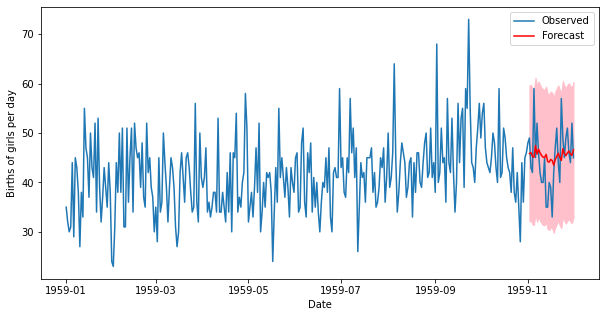

In [ ]:
plt.figure(figsize = (10, 5))

plt.plot(y_train.index, y_train, label='Observed');

# Plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='Forecast');

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink');

# Set labels, legends
plt.xlabel('Date');
plt.ylabel('Births of girls per day');
plt.legend();

In this case the result of the plot is more interpretable and seems to be realistic. 

<hr color=grey>

11) **Auto_arima model** 

This example demonstrates how we can use the ``auto_arima`` function to
select an optimal time series model. 👀


ARIMAResults include aic and bic . By their definition , these criteria penalise the number of parameters in the model. But it is possible to use a special library: 

Now there is a proper python package to make auto-arima. https://github.com/tgsmith61591/pmdarima

Doctors: http://alkaline-ml.com/pmdarima

In [ ]:
!pip install pmdarima 

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [ ]:
import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error

In [ ]:
# fitting a stepwise model:
modl = pm.auto_arima(y_train, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                     stepwise=True, # set to stepwise
                     suppress_warnings=True, # don't want convergence warnings
                     D=10, 
                     max_D=10, 
                     error_action='ignore')  # don't want to know if an order does not work


# Create predictions for the future, evaluate on test
preds, conf_int = modl.predict(n_periods=y_test.shape[0], return_conf_int=True)

# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(y_test, preds)))

Test RMSE: 7.159


Text(0.5, 0, 'Date')

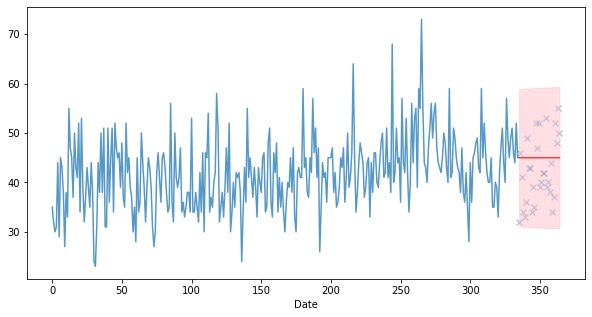

In [ ]:
# Plot the points and the forecasts
plt.figure(figsize = (10, 5))
x_axis = np.arange(y_train.shape[0] + preds.shape[0])
x_years = x_axis 

plt.plot(x_years[x_axis[:y_train.shape[0]]], y_train, alpha=0.75, label='Observed')
plt.plot(x_years[x_axis[y_train.shape[0]:]], preds, alpha=0.75, label='Forecast', color='red')  # Forecasts
plt.scatter(x_years[x_axis[y_train.shape[0]:]], y_test,
            alpha=0.4, marker='x')  # Test data
plt.fill_between(x_years[x_axis[-preds.shape[0]:]],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.5, color='pink')
plt.xlabel("Date")

Here we see that if you are unsure of the best parameters for your model, let auto_arima figure it out for you. auto_arima is similar to an ARIMA-specific grid search, but (by default) uses a more intelligent stepwise algorithm

In the plot the axis is a days in 1959 year from 0 (that is 1959-01-01) to 364 (that is 1959-12-31)